<figure>
  <IMG SRC="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d5/Fachhochschule_Südwestfalen_20xx_logo.svg/320px-Fachhochschule_Südwestfalen_20xx_logo.svg.png" WIDTH=250 ALIGN="right">
</figure>

# Programmierung für KI
### Winterersemester 2025/26
Prof. Dr. Heiner Giefers

**Achtung:** Im folgenden Aufgabenblatt sind einige Funktionen enthalten, die Sie zur Lösung der Aufgaben *verwenden* müssen. Sie müssen die Implementierung der Funktionen nicht unbedingt *verstehen*, um sie zu verwenden. Um möglichst viele Aufgaben zu lösen, verwenden Sie die Funktionen einfach "wie sie sind" und schauen Sie sich die Details im Nachgang an.

# Sprache von Texten erkennen

In dieser Aufgabe wollen wir uns mit dem Problem beschäftigen, die Sprache zu bestimmen, in der ein gewisser Text verfasst ist.
Es gibt verschiedenste Ansätze, dieses Problem zu lösen.
Wir werden ein sehr einfaches, Daten-getriebenes Verfahren einsetzen, bei dem die charakteristische *Buchstabenhäufigkeit* einer Sprache verwendet wird.

Die Idee ist folgende: In den verschiedenen Sprachen kommen bestimmte Buchstaben unterschiedlich häufig vor.
Im Englischen, zum Beispiel, ist das *y* deutlich häufiger als im Deutschen, im Französischen ist das *e* (ohne Akzent) wahrscheinlich seltener als in anderen Sprachen.

Wenn wir bestimmen, wie häufig die einzelnen Buchstaben in einer Sprache *im Allgemeinen* vorkommen, haben wir eine Art *Fingerabdruck* der Sprache. Für einen neuen Text, zu dem wir die Sprache nicht kennen, können wir ebenfalls die Buchstabenhäufigkeit berechnen und anschließend diese Verteilung mit allen Sprach-Fingerabdrücken vergleichen. Unsere Annahme ist, dass der Fingerabdruck, zu dem unsere Buchstaben-Verteilung am besten passt, zur Sprache gehört, in der auch der Text verfasst ist.

Im Folgenden wollen wir versuchen herauszufinden, ob diese Idee funktioniert. Dazu müssen wir folgende Teilprobleme lösen:

1. Wir müssen **Texte in verschiedenen Sprachen beschaffen**. Diese Texte müssen jeweils möglichst repräsentativ für die Sprache sein. Fachtexte oder andere *spezielle* Texte sollten eher vermieden werden.
1. Wir müssen in den Texten die Buchstaben analysieren und die **relative Häufigkeit jedes Buchstaben bestimmen**. Dieser Schritt muss für alle Sprachen wiederholt werden.
1. Um das Verfahren zu testen, müssen wir neue, diesmal kürzere Textpassagen beschaffen. Wir können die gleichen Funktionen wie im Schritt zuvor verwenden, um die Buchstabenhäufigkeit zu bestimmen.
1. Wir benötigen einen Weg um herauszufinden, wie *ähnlich* zwei verschiedene Häufigkeitsverteilungen sind. Wir werden hierfür die **Abweichung zwischen den Verteilungen** bestimmen und das Minimum dieser Abweichungen als Ergebnis auswählen.

### Schritt 1: Texte in verschiedenen Sprachen beschaffen
Um die mittleren Buchstabenhäufigkeiten in den verschiedenen Sprachen zu ermitteln, brauchen wir zunächst einmal **Daten**.
Eine recht gute Quelle für Texte in verschiedenen Sprachen, ist [Wikipedia](https://www.wikipedia.org).
Von dort werden wir verschiedene, zufällige Seiten in den unterschiedlichen Sprachen aufrufen und den Textinhalt dieser Seiten herunterladen.
Für den Zugriff auf Wikipedia Seiten empfiehlt sich die Installation des Python-Pakets *Wikipedia-API*.
Falls nicht vorhanden, installieren wir dieses Paket direkt aus dem Notebook heraus.

In [2]:
try:
    import wikipediaapi
except:
    import sys
    !{sys.executable} -m pip install wikipedia-api

In der nächsten Code-Zelle werden die Methoden `random_page` und `random_text` implementiert.
`random_text(size,lang)` liefert einen Text mit `size` Zeichen in der Sprache `lang`.
Um zufällige Wikipedia-Seiten herunterzuladen wir die Methode `random_page` verwendet.
Wikipedia bietet über die URL [wikipedia.org/wiki/Special:Random](http://wikipedia.org/wiki/Special:Random) die Möglichkeit, eine zufällige Seite auszuwählen.
Über diese URL holen wir uns den Titel der zufälligen Seite und laden den Inhalt schließlich mit der Wikipedia-API herunter.

In [3]:
import re
import requests
from bs4 import BeautifulSoup
import wikipediaapi

def random_page(wiki, lang="de"):
    ''' Die Funktion liefert den Inhalt (Text) einer zufälligen 
    Wikipedia-Seite zurück
    
    Parameter
    --------------------
    wiki: Ein "Wikipedia"-Objekt des Moduls wikipediaapi
    lang: Ein Sprach-Kuerzel, dass die entsprechende Wikipedia-Sprache bezeichnet.
          Beispiele sind "en" (Englisch), "de" (Deutsch), "es" (Spanisch), "fr" (Französisch).
          Default ist "de"
          
    Return
    --------------------
    Der Inhalt der zufällig ausgewählten Seite
    '''
    headers = {
    'User-Agent': 'Sprachen_erkennen',
    }
    r = requests.get("https://" + lang + ".wikipedia.org/wiki/Special:Random", headers=headers)
    soup = BeautifulSoup(r.content)
    # Schneitet 12 Buchstaben vom Ende ab
    # Funktioniert nicht bei allen Sprachen
    #page = wiki.page(soup.title.text[:-12])
    # Such nach "Wikip" im Titel
    # Nimm den vorderen Teil ohne " - " (3 Buchstaben)
    title = soup.title.text.split('Wikip')[0]
    page = wiki.page(title[:-3])
    assert page.exists(), f"Die Seite {page} in {lang} ibt es nicht"
    return page.text

def random_text(size,lang="de"):
    ''' Die Funktion liefert einen von Sonderzeichen bereinigten Text
    der länge "size" (in Zeichen) in der Sprache "lang" zurück
    
    Parameter
    --------------------
    zize: Die geforderte Länge des Textes in Zeichen
    lang: Ein Sprach-Kuerzel, dass die entsprechende Sprache bezeichnet.
          Beispiele sind "en" (Englisch), "de" (Deutsch), "es" (Spanisch), "fr" (Französisch).
          Default ist "de"
          
    Return
    --------------------
    String der länge "size" in der Sprache "lang"
    '''
    WIKI = wikipediaapi.Wikipedia(
        user_agent="Sprachen_erkennen",
        language=lang,
        extract_format=wikipediaapi.ExtractFormat.WIKI
    )
    text = ''
    while(len(text)<size):
        t = random_page(WIKI, lang)
        # Übersetze Umlaute
        de_table = str.maketrans({'Ä': 'Ae', 'Ö': 'Oe', 'Ü': 'Ue', 
                          'ä': 'ae', 'ö': 'oe', 'ü': 'ue', 'ß': 'ss'})
        t = t.translate(de_table)
        # Entferne alles, was kein Buchstabe oder Leerzeichen ist
        t_cleaned = re.sub('[^a-zA-Z ]', '', t)
        #Alles zu Kleinbuchstaben
        t_cleaned = t_cleaned.lower()
        text += t_cleaned

    return text[:size]


Wir können nun die Funktion `random_text` verwenden, um einen String mit beliebiger Länge in verschiedenen Sprachen zu erzeugen.
Im folgenden Beispiel erzeigen wir einen String `de_text_500` aus dem Deutschen mit genau 500 Zeichen

In [4]:
de_text_500 = random_text(500,"de")
print(de_text_500)

hubert muetherich   november  in lippstadt   september  bei krasnoje selo war ein offizier der deutschen luftwaffe und jagdflieger im zweiten weltkriegmuetherich war staffelkapitaen der  staffel des jagdgeschwaders  gruenherz er schoss  feindliche flugzeuge ab und wurde am  august  mit dem ritterkreuz des eisernen kreuzes ausgezeichnet einzelnachweise julius schindler geboren am  mai  in maehrischtruebau schoenhengstgau oesterreichungarn gestorben am  dezember  in great neck new york vereinigte 


Zeichenweise durchlaufen, können wir diesen String wie jede Zeichenkette, ganz einfach mit `for`:

In [5]:
for z in de_text_500:
    #Drucke jedes Zeichen und danach jeweils ein '-'
    print(z,end='-')

h-u-b-e-r-t- -m-u-e-t-h-e-r-i-c-h- - - -n-o-v-e-m-b-e-r- - -i-n- -l-i-p-p-s-t-a-d-t- - - -s-e-p-t-e-m-b-e-r- - -b-e-i- -k-r-a-s-n-o-j-e- -s-e-l-o- -w-a-r- -e-i-n- -o-f-f-i-z-i-e-r- -d-e-r- -d-e-u-t-s-c-h-e-n- -l-u-f-t-w-a-f-f-e- -u-n-d- -j-a-g-d-f-l-i-e-g-e-r- -i-m- -z-w-e-i-t-e-n- -w-e-l-t-k-r-i-e-g-m-u-e-t-h-e-r-i-c-h- -w-a-r- -s-t-a-f-f-e-l-k-a-p-i-t-a-e-n- -d-e-r- - -s-t-a-f-f-e-l- -d-e-s- -j-a-g-d-g-e-s-c-h-w-a-d-e-r-s- - -g-r-u-e-n-h-e-r-z- -e-r- -s-c-h-o-s-s- - -f-e-i-n-d-l-i-c-h-e- -f-l-u-g-z-e-u-g-e- -a-b- -u-n-d- -w-u-r-d-e- -a-m- - -a-u-g-u-s-t- - -m-i-t- -d-e-m- -r-i-t-t-e-r-k-r-e-u-z- -d-e-s- -e-i-s-e-r-n-e-n- -k-r-e-u-z-e-s- -a-u-s-g-e-z-e-i-c-h-n-e-t- -e-i-n-z-e-l-n-a-c-h-w-e-i-s-e- -j-u-l-i-u-s- -s-c-h-i-n-d-l-e-r- -g-e-b-o-r-e-n- -a-m- - -m-a-i- - -i-n- -m-a-e-h-r-i-s-c-h-t-r-u-e-b-a-u- -s-c-h-o-e-n-h-e-n-g-s-t-g-a-u- -o-e-s-t-e-r-r-e-i-c-h-u-n-g-a-r-n- -g-e-s-t-o-r-b-e-n- -a-m- - -d-e-z-e-m-b-e-r- - -i-n- -g-r-e-a-t- -n-e-c-k- -n-e-w- -y-o-r-k- -v-e-r-e-i-n-i-g-t-e- -

Um aus der Zeichenkette auf einzelne Worte zu schließen, müssen wir den Text an den stellen der Leerzeichen *aufsplitten*.

**Aufgabe:** Verwenden Sie die Funktion `random_text` um einen Englischen Text mit 200 Zeichen zu erzeugen. Teilen Sie den Text in einzelne Worte auf, die in der Liste `worte` abgelegt sind. Die `for`-Schleife durchläuft diese Liste und gibt die einzelnen Worte aus.

Die erwartete Ausgabe sieht etwa so aus:
```
0) mara 1) santangelo 2) was 3) the 4) defending 5) champion 6) however 7) she 8) chose 9) not 10) to 11) compete 12) this 13) yearpetra 14) marti 15) won 16) her 17) maiden 18)  19) title 20) defeating 21) sharon 22) fichman 23) in 24) the 25) final 26)  27) seedsdrawkeyfinalstop 28) halfbottom 29) halfrefer 
``` 

Die konkreten Worte kommen dabei aus zufällig ausgewählten Seiten und sind daher i.d.R. unterschiedlich.

In [ ]:
worte = None
random_text_en_200 = random_text(200,"en")
worte = random_text_en_200.split(" ")

for i, wort in enumerate(worte):
    print(f"{i}) {wort}", end=' ')

0) runa 1) is 2) an 3) unincorporated 4) community 5) in 6) nicholas 7) county 8) west 9) virginia 10) united 11) states 12) runa 13) is 14)  15) miles 16)  17) km 18) south 19) of 20) summersvillethe 21) community 22) was 23) named 24) after 25) runa 26) mcclung 27) the 28) sister 29) of 30) an 31) early 32) settler 33) ref 

### Schritt 2: Relative Häufigkeiten der Buchstaben bestimmen
Uns interessieren aber weniger die Worte, als die einzelnen Buchstaben.

**Aufgabe:** Bestimmen Sie die relativen Häufigkeiten der Buchstaben im Text.

Dazu verwenden wir ein *Dictionary* `buchstaben`, das zu Anfang leer ist und gehen folgendermaßen vor:
1. Wir durchlaufen alle Buchstaben des Textes (wie im Beispiel weiter oben).
2. Wir prüfen, ob der aktuelle Buchstabe als *key* im Dictionary vorkommt
    1. Falls er nicht vorkommt, fügen wir den Buchstaben als Schlüssel hinzu und setzen den Wert des Schlüssels auf 1.
    2. Falls er vorkommt, erhöhen wir den Wert des Eintrags um 1
3. Nachdem alle Buchstaben des Textes verarbeitet sind, durchlaufen wir alle Schlüssel des Dictionaries `buchstaben` und teilen jeden Wert durch die Anzahl der Buchstaben im Text. Beispiel: Wenn der Text 1000 Zeichen hat und der Wert `buchstaben['e']` gleich 100 ist, so setzen wir `buchstaben['e']` auf 0.1

In [13]:
def letter_frequency(text):
    buchstaben = {}
    for buchstabe in text:
        if buchstabe not in buchstaben:
            buchstaben[buchstabe] = 1
        else:
            buchstaben[buchstabe] += 1
    alle_buchstaben = len(text)
    for key in buchstaben:
        buchstaben[key] /= alle_buchstaben
    return buchstaben

# print(letter_frequency("pizza"))


In [14]:
# Test Zelle
test_freq = letter_frequency("pizza")
assert 'z' in test_freq
assert 'e' not in test_freq
assert test_freq['z']==0.4

Wir haben nun eine Methode `letter_frequency`, mit der wir die relativen Häufigkeiten der Buchstaben eines Textes bestimmen können.
Um einen ersten Eindruck von diesen Häufigkeiten zu bekommen, werden wir ein Säulendiagramm erstellen.
Dazu verwenden wir die Bibliothek `matplotlib`

Matplotlib is building the font cache; this may take a moment.


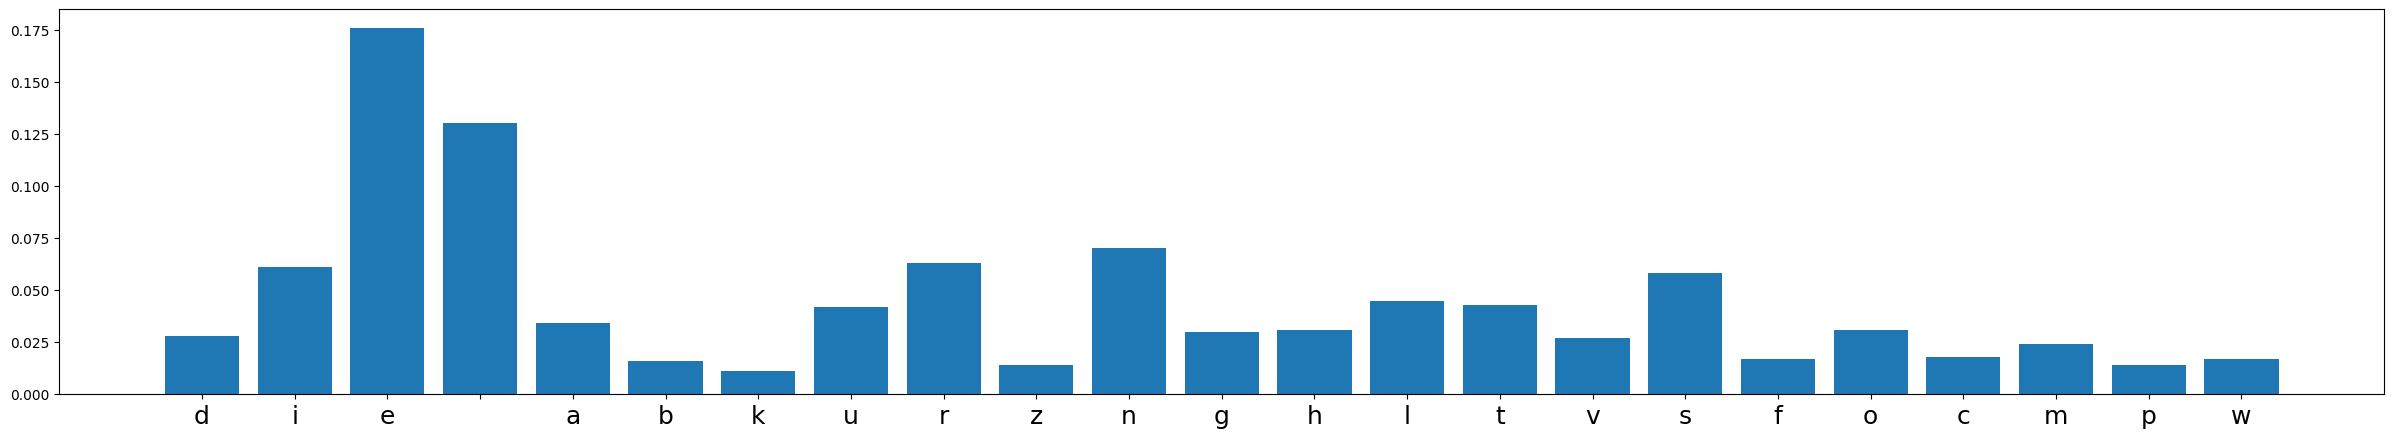

In [15]:
import numpy as np
import matplotlib.pyplot as plt

text = random_text(1000, 'de')
buchstaben = letter_frequency(text)

plt.figure(figsize=(30,5)) 

x = range(len(buchstaben))
y = list(buchstaben.values())
x_ticks = list(buchstaben.keys())
plt.bar(x, y, align='center')
plt.xticks(x, x_ticks, rotation=0, fontsize=18)
plt.show()

Wie man sieht, sind die Einträge im Dictionary unsortiert.
Weder die Schlüssel noch die Werte folgen einer Ordnung.

Um die Buchstabenhäufigkeiten aber später vergleichen zu können, wollen wir einen *Vektor* erzeugen, bei dem Buchstaben immer an gleicher Stelle stehen. Z.B. `a` an Index 0, `b` an Index 1, usw.
Eine Idee könnte sein, die Schlüssel zu sortieren.
Hierbei ist aber Vorsicht geboten, denn es könnt sein, dass ein Buchstabe im Text nicht vorkommt.
In dem Fall, hätte der Vektor zu wenige Einträge.

Wir verfolgen daher einen anderen Weg.
Über eine `for`-Schleife zählen wir alle Buchstaben von *a* bis *z* auf, schauen nach, ob sie im Dictionary enthalten sind und übernehmen den Wert in eine Liste.
Ist der Buchstabe nicht enthalten, übernehmen wir den Wert 0.0 in die Liste.

Eine Schleife, die alle Buchstaben durchläuft könnte so aussehen
```pypthon
for i in range(ord('a'), ord('z')+1):
    print(chr(i), end=' ')
```

`ord('a')` liefert den ASCII Code des Zeichens *a*.
So kann die Schleife die ASCII Codes von *a* bis *z* durchlaufen.
Im Schleifenrumpf erzeugen wir aus dem ASCII Code mit der Typumwandlung `chr` wieder ein Zeichen.

**Aufgabe:** Schreiben Sie eine Funktion `frequency_vector(d)`, die aus einem Dictionary `d` ein Tupel mit 26 Einträgen erzeugt, in denen jeweils die relative Häufigkeit der Buchstaben von  *a* bis *z* im Text steht.

In [17]:
def frequency_vector(d):
    f = []
    for i in range(ord('a'), ord('z')+1):
        letter = chr(i)
        if letter in d: 
            f.append(d[letter])
        else: 
            f.append(0.0)
    return tuple(f)
    
#frequency_vector({'a': 0.5, 'd': 0.5})

In [18]:
# Test Zelle
test_d = {'a': 0.5, 'd': 0.5}
test_l = [0.0]*26
test_l[0]=0.5
test_l[3]=0.5
assert frequency_vector(test_d)==tuple(test_l)

In der folgenden Code-Zelle werden die zuvor entwickelten Funktionen verwendet, um die relativen Häufigkeiten der Buchstaben in den Sprachen *Deutsch*, *Englisch*, *Spanisch* und *Französisch* zu bestimmen.
Wir verwenden dazu jeweils 10000 Zeichen aus Wikipedia Artikeln.
Die Resultate werden im Dictionary `haeufigkeiten` unter den Schlüsseln `'de'`, `'en'`, `'es'` und `'fr'` abgelegt.

In [19]:
languages = ['de', 'en', 'es', 'fr']

def get_lang_freq(lang):
    text = random_text(10000, lang)
    buchstaben = letter_frequency(text)
    return frequency_vector(buchstaben)

haeufigkeiten = {}
for l in languages:
    haeufigkeiten[l] = get_lang_freq(l)

### Schritt 3: Textpassage in einer Sprachen beschaffen

Nun haben wir verschiedene Vektoren, die wir als Maßstab für die einzelnen Sprachen verwenden können.
Als Nächstes wollen wir überprüfen, ob wir diese Vektoren verwenden können, um für einen neuen Text vorherzusagen, in welcher Sprache er geschrieben ist.

Dazu definiert die folgende Code-Zelle die Funktion `get_page_freq`, mit der wir den Inhalt einer speziellen Wikipedia-Seite herunterladen und die relative Häufigkeit der Buchstaben in dieser Seite berechnen können.

In [20]:
def get_wiki_page(term, lang='de'): 
    WIKI = wikipediaapi.Wikipedia(
          user_agent="Sprachen_erkennen",
          language=lang,
          extract_format=wikipediaapi.ExtractFormat.WIKI
    )
    page = WIKI.page(term)
    assert page.exists()
    t = page.text
    # Umlaute entfernen
    de_table = str.maketrans({'Ä': 'Ae', 'Ö': 'Oe', 'Ü': 'Ue', 
                    'ä': 'ae', 'ö': 'oe', 'ü': 'ue', 'ß': 'ss'})
    t = t.translate(de_table)
    # Entferne alles, was kein Buchstabe oder Leerzeichen ist
    t_cleaned = re.sub('[^a-zA-Z ]', '', t)
    #Alles zu Kleinbuchstaben
    return t_cleaned


def get_page_freq(term, lang='de'):
    text = get_wiki_page(term, lang=lang)
    buchstaben = letter_frequency(text)
    return frequency_vector(buchstaben)

mypage = get_page_freq("Hochschule")

### Schritt 4: Häufigkeiten vergleichen (Fehler bestimmen)

An dieser Stelle haben wir fünf Vektoren, je einen, der die Häufigkeiten der Buchstaben in den Sprachen *Deutsch*, *Englisch*, *Spanisch* und *Französisch* beschreibt sowie einen weiteren, mit den relativen Häufigkeiten der Buchstaben in *unserem* Text.
Nun wollen wir ausrechnen, zu welchem der vier Sprach-Vektoren unser Buchstaben-Vektor *am ähnlichsten* ist, bzw. zu welchem Sprach-Vektor er die wenigsten Unterschiede aufweist.

Wir werden also die einzelnen Buchstaben-Häufigkeiten in unserem Vektor mit denen im Sprach-Vektor *vergleichen*.
Mathematisch gesehen, bilden wir die Differenz der Häufigkeiten aller einzelnen Buchstaben.
Kommt z.B. in unserem Text das *e* zu 10% und im Sprach-Vektor zu 8% vor, so ist die Abweichung $0.1-0.08=0.02$ für den Buchstaben *e*.

Die folgende Abbildung zeigt ein Beispiel anhand zweier Sprachen und den Buchstaben *a, e, i, o, u*.
Vergleicht man die Häufigkeiten der Sprachen *1* und *2* jeweils mit der Häufigkeit der Buchstaben im Text, so ergibt sich für jeden Buchstaben ein Fehler. Da der Fehler für die "gelbe" Sprache geringer ist, gehen wir davon aus, dass der Text mit einer höheren *Wahrscheinlichkeit* zur ("gelben") Sprache 2 als zur ("blauen") Sprache 1 gehört.

![](https://github.com/fhswf/datasets/raw/main/images/letterfreq.png)

Wenn wir nun alle Abweichungen aufsummieren, kann es zu einem Problem kommen.
Manche Differenzen werden positiv, andere negativ sein.
Eine einfache Summe wird die negativen und positiven Abweichungen gegeneinander aufrechen.

Um dieses Problem zu beheben, gibt es verschiedene Möglichkeiten.
Man kann die Absolutwerte der Abweichungen aufsummieren, oder auch deren Quadratwerte.
In jedem Fall wird die Summe am Ende durch die Anzahl der Einträge des Vektors geteilt, um den Mittleren Fehler zu berechnen.

Verwendet man zum Berechnung die Absolutwerte, nennt man das Maß [*Mittlerer absoluter Fehler*](https://de.wikipedia.org/wiki/Mittlerer_absoluter_Fehler) (oder *mean absolute error*), verwendet man die Fehlerquadrate heißt das Maß [*Mittlerer quadratischer Fehler*](https://de.wikipedia.org/wiki/Mittlere_quadratische_Abweichung) (oder *mean squared error*).

**Aufgabe:** Implementieren Sie die Funktion `mse` zur Berechnung des Mittleren Quadratischen Fehlers. 

*Hinweise:*
- Die Funktion soll zwei mit `for` iterierbare Objekte `a` und `b` (z.B. *Listen* oder *Tupel*) gleicher Länge als Parameter übergeben bekommen.
- Die Funktion berechnet die Differenzen der Werte an gleichen Index-Positionen.
- Da diese Differenten positiv oder negativ sein können, bilden wir jeweils das Quadrat und summieren diese quadrierten Fehler-Werte auf.
- Am Ende soll die Funktion den Mittleren quadratischen Fehler mit `return` zurückgeben.

*Beispiel:* Für die Beiden Listen `x` und `y` ist der mittlere quadratische Fehler gleich 2:
```
x = [1,2,3,5]
y = [3,2,5,5]
```

$\text{MSE} = \frac{(1-3)^2 + (2-2)^2 + (3-5)^2 + (5-5)^2}{4} = \frac{(-2)^2 + 0^2 + (-2)^2 + 0^2}{4} = \frac{4 + 0 + 4 + 0}{4} = \frac{8}{4} = 2$ 


In [21]:
def mse(a,b):
    zaehler = 0
    nenner = len(a)
    for index, value in enumerate(a):
        zaehler += (value - b[index])**2
    return zaehler / nenner
                
mse([1,2,3,4,5],[3,2,5,4,5])

1.6

In [22]:
# Test Zelle
a = [1,2,3,4,5]
b = [3,2,5,4,5]
assert mse(a,b)==1.6

Nun können wir unsere Vektoren vergleichen und herausfinden, zu welcher Sprache unser Vektor am ähnlichsten ist.

In [23]:
def get_prop(mypage, languages):
    fehler = {}
    for l in languages:
        fehler[l] = mse(mypage,languages[l])

    fehlersumme = sum(fehler.values())

    props = {}
    for f in fehler:
        props[f] = 100-fehler[f]*100/fehlersumme


    prop_sum = sum(props.values())

    for f in props:
        props[f] = props[f]*100/prop_sum

    return props

p = get_prop(mypage, haeufigkeiten)
p

{'de': 30.16210048784816,
 'en': 25.311370610168197,
 'es': 19.045948819228578,
 'fr': 25.48058008275506}

Das Dictionary `p` enthält die berechneten Wahrscheinlichkeiten, mit denen der Text in den jeweiligen Sprachen verfasst ist.
Man sollte sehen, dass bei einem deutschen Text, der key `'de'` den höchsten Wert enthält. 

### Ausblick: n-Gramme statt Buchstaben verwenden

Wie man sieht, ist die Häufigkeit der verschiedenen Buchstaben ein mögliches Vorhersagekriterium, allerdings kein sehr gutes. Die Wahrscheinlichkeiten für Deutsch und Englisch sind i.d.R. nicht sehr verschieden.

Um das Verfahren zu verbessern, könnte man statt einzelne Buchstaben ganze Worte betrachten.
Oder alternativ dazu, Sequenzen von $n$ aufeinanderfolgenden Buchstaben, den sogenannten [n-Grammen](https://de.wikipedia.org/wiki/N-Gramm).

Wenn man einen Text auf n-Gramme untersucht, betrachtet man Folgen von $n$ Buchstaben von jedem Buchstaben aus.
In der folgenden Code-Zelle verwenden wir das Wort *Waschmaschine* als Beispiel.
Das Wort hat 13 Buchstaben und besitzt damit 11 Trigramme (3-Gramme) von denen eines (das *sch*) doppelt vorkommt.

In [ ]:
wort = 'waschmaschine'
def n_gramm(wort, n =3):
    return [wort[i:i+n] for i in range(len(wort)-n + 1)]


['wasc',
 'asch',
 'schm',
 'chma',
 'hmas',
 'masc',
 'asch',
 'schi',
 'chin',
 'hine']

**Aufgabe:** 
1. Generieren Sie einen zufälligen Text mit 2000 Zeichen
2. Teilen Sie den Text so auf, dass Sie die einzelnen Worte in einer Liste ablegen. Berechnen Sie die 3-Gramme für alle Worte im Text und speichern Sie die 3-Gramme in einer Liste
3. Es sollen nur die 3-Gramme betrachtet werden. D.h, wenn ein Wort weniger als 3 Buchstaben besitzt, nehmen Sie es nicht in die Liste auf
4. Geben Sie die Anzahl aller 3-Gramme aus, die in ihrem Text enthalten sind
5. Geben Sie die Anzahl aller eindeutigen 3-Gramme aus, d.h. ohne doppelte Vorkommen

In [40]:
# 1 
random_text_2k_de = random_text(2000)
print(print(f"2. & 3.: {random_text_2k_de}"))
# 2 & 3
n_gramm_list = [ n_gramm_atom for wort in random_text_2k_de.split(" ") for n_gramm_atom in n_gramm(wort)] # ich weiß, dass ist dummer Code. War nur ein Test
print(f"2. & 3.: {n_gramm_list}")
# 4
print(f"4. Anzahl aller 3-Gramme: {len(n_gramm_list)}")
# 5
print(f"5. Anzahl aller eindeutigen 3-Gramme: {set(n_gramm_list)}")
print(f"5. Anzahl aller eindeutigen 3-Gramme: {len(set(n_gramm_list))}")

2. & 3.: das castello di panocchia ist eine spaetmittelalterliche niederungsburg neben der kirche san donnino in panocchia einem ortsteil von parma in der italienischen region emiliaromagna sie liegt in der via campana geschichtedie burg deren geschichte nahezu unbekannt ist wurde vermutlich zwischen dem ende des  und dem beginn des  jahrhunderts im auftrag der grafen cantelli lehensleute von panocchia errichtet die familie besass schon spaetestens ab  ein gebaeude in der siedlungnach dem tod des letzten grafen paolo cantelli  erbte der markgraf alfonso bevilacqua der grossneffe des erblassers das gebaeude und fuegte seinem eigenen familiennamen den seines grossonkels hinzudas gebaeude das mehrmals umgebaut wurde wurde zur sommerresidenz der familie die dort verschiedene bekannte persoenlichkeiten zu gast hatte darunter den dichter carlo innocenzo frugoni der in einem seiner werke seinen dortigen aufenthalt aufgeschrieben hatbeschreibungdas gebaeude das resultat von umbauarbeiten ueber